In [4]:
# misc
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.utils import shuffle

# import matplotlib
%matplotlib inline
import matplotlib

plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams['figure.facecolor'] = 'white'

# import gpy
import gpflow as gpf
from gpflow.utilities import print_summary
gpf.config.set_default_summary_fmt("notebook")
import tensorflow as tf

                           airtemp  cloudcover  precip  107337_00065  \
2008-01-01 06:15:00+00:00     -7.0         2.0     0.0          4.88   
2008-01-01 06:30:00+00:00     -7.5         3.0     0.0          4.88   
2008-01-01 06:45:00+00:00     -8.0         3.0     0.0          4.88   
2008-01-01 07:00:00+00:00     -7.5         1.9     0.0          4.88   
2008-01-01 07:15:00+00:00     -7.0         1.8     0.0          4.87   

                           107338_00010  
2008-01-01 06:15:00+00:00           1.9  
2008-01-01 06:30:00+00:00           1.9  
2008-01-01 06:45:00+00:00           1.9  
2008-01-01 07:00:00+00:00           1.9  
2008-01-01 07:15:00+00:00           1.9  


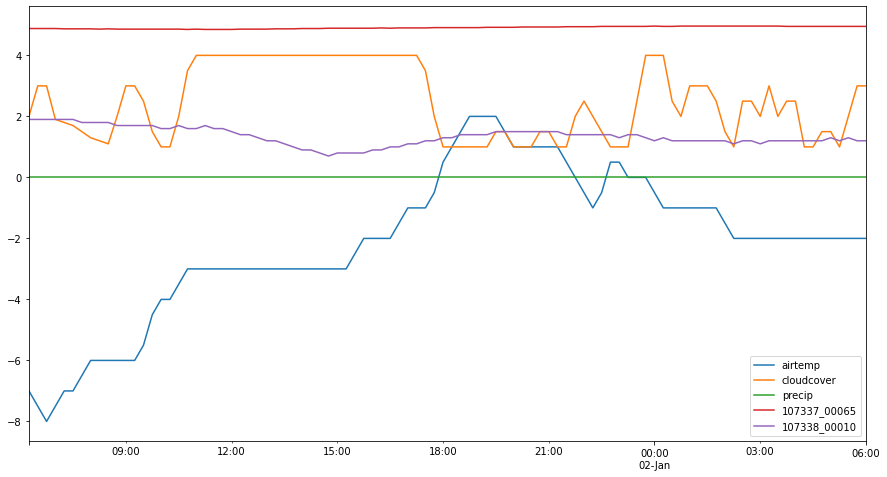

In [5]:
observations = pd.read_pickle('output/observations.pickle')

# to make this data better suited for regression, we'll run it through savitzky golay to smooth
# observations = observations.apply(lambda d: savgol_filter(d, 25, 3))

print(observations.head())
observations.head(4 * 24).plot()
plt.show()

observations = observations.tail(4 * 24 * 30)
observations = observations.values

In [6]:
N = observations.shape[0]
D = 3
M = 4*24
L = 2
P = 1
batch_size = 4*24
# MAXITER = gpf.test_util.notebook_niter(15000)

X, Y = observations[:, :3], observations[:, 3:4]
data = (X, Y)

kernel = gpf.kernels.SharedIndependent(
    # gpf.kernels.Periodic(gpf.kernels.RBF(D), period=4*24*365) +
        gpf.kernels.Periodic(gpf.kernels.RBF(D), period=4*24) +
        gpf.kernels.Linear(D) +
        gpf.kernels.RBF(D),
    output_dim=P)

Z = shuffle(X[:M].copy())

iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

# batched_data = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
opt = gpf.optimizers.Scipy()
training_loss = m.training_loss_closure(data)
opt_logs = opt.minimize(training_loss, m.trainable_variables, options=dict(disp=True, maxiter=5000))

print_summary(m)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-29 22:51:13.885375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 22:51:13.885608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-29 22:51:16.509078: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-29 22:51:16.511549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5047     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58230D+05    |proj g|=  1.58700D+05

At iterate    1    f=  3.81967D+04    |proj g|=  3.07134D+04

At iterate    2    f=  2.36473D+04    |proj g|=  1.74787D+04

At iterate    3    f=  1.58487D+04    |proj g|=  5.68991D+03

At iterate    4    f=  1.37745D+04    |proj g|=  4.33847D+03

At iterate    5    f=  1.12059D+04    |proj g|=  3.71396D+03

At iterate    6    f=  8.56461D+03    |proj g|=  3.38553D+03

At iterate    7    f=  7.33942D+03    |proj g|=  4.42788D+03

At iterate    8    f=  6.55951D+03    |proj g|=  9.07937D+02

At iterate    9    f=  6.18847D+03    |proj g|=  6.45119D+02

At iterate   10    f=  5.75582D+03    |proj g|=  5.40220D+02

At iterate   11    f=  5.69662D+03    |proj g|=  2.71365D+03

At iterate   12    f=  5.50462D+03    |proj g|=  7.27571D+02

At iterate   13    f=  5.4

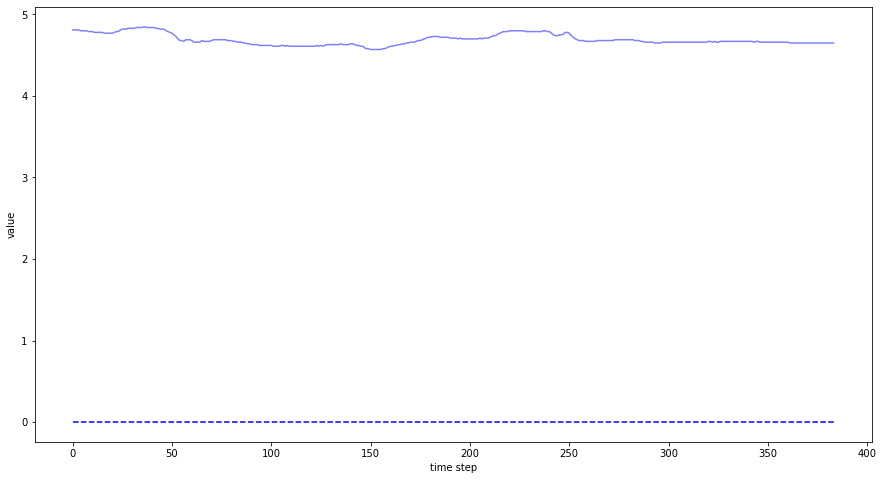

In [23]:
# predict
num_pred = 4 * 24 * 4
pX = X[180:180 + num_pred]
pY, pYv = m.predict_y(pX)

# plt.plot(X)
plt.plot(Y[180:180 + num_pred, 0], c='blue', alpha=0.5)
# plt.plot(Y[180:180 + num_pred, 1], c='red', alpha=0.5)

for i in range(pY.shape[1]):
  top = pY[:, i] + 2 * pYv[:, i] ** .5
  bot = pY[:, i] - 2 * pYv[:, i] ** .5
  # plt.fill_between(range(num_pred), top, bot, alpha=0.3)

plt.plot(pY[:, 0], '--', c='blue')
# plt.plot(pY[:, 1], '--', c='red')

plt.xlabel('time step')
plt.ylabel('value')
plt.show()